In [14]:
import numpy as np
import pandas as pd
import random
import shap
from math import sqrt
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [5]:
#individuals
n = 2000
#loci
m = 100


#here every matrix entree has to be zero or one, with having a f_i probability to get selected
#frequency of alleles, random uniform distribution between 0 and 1, with m samples
f_M = np.random.uniform(0,1,m)

#initialize G matrix
# G = np.zeros((n, m));

# #will be used to flip a coin based on f_i
# #higher f_i frequency = higher chance of returning true
# def loci_frequency_flip(f_i):
#     return random.random() < f_i

# #use this if I wanted to populate entire G matrix
# #k are the colums(loci)
# for k in range (0, len(G[0])):
#     # j are the rows(individuals)
#     for j in range (0, len(G)):
#         #frequency of loci k we are currently on
#         if(loci_frequency_flip(f_M[k])):
#             G[j,k] = 1

G = np.random.binomial(n=2,p = f_M, size =  (n,m))

# If 0, independently standardize each feature, otherwise (if 1) standardize each sample, so choosing 0 
# to do column wise scaling
G = preprocessing.scale(G, axis=0)
# choose random SNP
loci =random.randint(0,m-1)

#select SNP
SNP = G[:,loci]

#preview of the data
print(SNP[0:30])

Data with input dtype int32 was converted to float64 by the scale function.


[ 0.77156388 -0.83251903  0.77156388  0.77156388 -0.83251903 -0.83251903
 -0.83251903  0.77156388 -0.83251903  0.77156388 -0.83251903 -0.83251903
 -0.83251903  0.77156388 -0.83251903 -0.83251903 -0.83251903 -0.83251903
  0.77156388 -0.83251903  0.77156388  0.77156388 -0.83251903  0.77156388
  0.77156388 -0.83251903 -0.83251903 -0.83251903  0.77156388 -0.83251903]


In [6]:

# mean and standard deviation
H=0
#assumes that we are making a Y_j for every individual in the SNP and 
#in each loop we choose a e_j for that person
def Simulate_Phenotype_PerPerson(SNP,var_e,var_g):
    #rows are the loci so each person has a row of different loci
    individuals = len(SNP)
    
    #where columns are the individuals
    mean = 0 
    
    #because we are given variance and python random.normal only accepts std, we need to convert variance to std
    sigma_e = sqrt(var_e)
    sigma_b = sqrt(var_g)
    
    #b_i = loci effect on phenotype
    b_i = np.random.normal(0, sigma_b)
    Y_n = np.zeros((individuals, 1));
    
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G_ij will be the jth individual from our SNP for the loci of choce
        G_ij  = SNP[k]
        Y_j = b_i*G_ij + e_j
        Y_n[k] = Y_j 
    H= var_g/(var_g+var_e)
    return Y_n,H


Phenotype Generation

In [7]:
#Generate Genotype
def generate_genotype(n, m, processing = True):
    f_M = np.random.uniform(0,1,m)
    G = np.random.binomial(n=2,p = f_M, size =  (n,m))
    if processing: 
        G = preprocessing.scale(G, axis=0)
    return G

#Generate base phenotype values
def generate_base_pheno_values(G, var_g, var_e, n_causal_SNPs):
    #rows are the loci so each person has a row of different loci
    individuals = len(G)    
    sigma_e = sqrt(var_e)
    sigma_b = sqrt(var_g/n_causal_SNPs)
    #b_i = loci effect on phenotype
    b_1 = np.random.normal(0, sigma_b)
    b_2 = np.random.normal(0, sigma_b)
    
    loci =random.sample(range(0, individuals), 2)
    SNP1 = G[:,loci[0]]
    SNP2 = G[:,loci[1]]
    return b_1, b_2, SNP1, SNP2, sigma_e, sigma_b

def generate_phenotype_additive(b_1, b_2, SNP1, SNP2, sigma_e, sigma_b, b_12):
    individuals = len(SNP1)    
    #rows are the loci so each person has a row of different loci
    Y_n = np.zeros((individuals, 1));
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G_ij will be the jth individual from our SNP for the loci of choice
        G_ij1  = SNP1[k]
        G_ij2  = SNP2[k]
        Y_j = (b_1*G_ij1) + (b_2*G_ij2) + (b_12 * G_ij1 * G_ij2)+ e_j 
        Y_n[k] = Y_j 
    return Y_n, b_12


In [42]:
G = generate_genotype(5, 10)
b_1, b_2, SNP1, SNP2, sigma_e, sigma_b = generate_base_pheno_values(G, 0.7, 0.3, 2)

b_list = []
#No Effect
b_12 = 0
Z = generate_phenotype_additive(b_1, b_2, SNP1, SNP2, sigma_e, sigma_b, b_12)
b_list.append(("Z", b_12))

#Random Combined Effect
b_12 = np.random.normal(0, sigma_b)
A = generate_phenotype_additive(b_1, b_2, SNP1, SNP2, sigma_e, sigma_b, b_12)
b_list.append(("A", b_12))
#0 < b_12 < b1
b_12 = random.uniform(0, abs(b_1))
B = generate_phenotype_additive(b_1, b_2, SNP1, SNP2, sigma_e, sigma_b, b_12)
b_list.append(("B", b_12))
#0 < b_12 < b2
b_12 = random.uniform(0, abs(b_2))
C = generate_phenotype_additive(b_1, b_2, SNP1, SNP2, sigma_e, sigma_b, b_12)
#b_list.append(("0 < b_12 < b_2", b_12))
b_list.append(("C", b_12))

#b_1 + b_2 < b_12
b_12 = random.uniform(abs(b_1) + abs(b_2), 1)
D = generate_phenotype_additive(b_1, b_2, SNP1, SNP2, sigma_e, sigma_b, b_12)
b_list.append(("D", b_12))

#b_12 < 0
b_12 = random.uniform(-1 * sigma_b, 0)
E = generate_phenotype_additive(b_1, b_2, SNP1, SNP2, sigma_e, sigma_b, b_12)
b_list.append(("E", b_12))

print(b_1)
print(b_2)
print(b_list)

Data with input dtype int32 was converted to float64 by the scale function.


0.18718406342450314
0.5709094033207736
[('Z', 0), ('A', -1.166428339271658), ('B', 0.09020084073995287), ('C', 0.2321932671273352), ('D', 0.8015896658284507), ('E', -0.5513002962811717)]


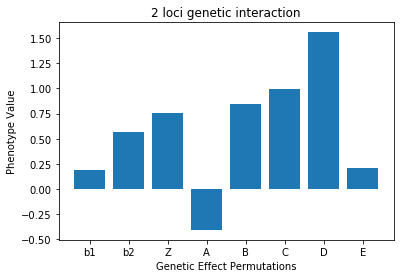

b_1 = 0.18718406342450314
b_2 = 0.5709094033207736
[('Z', 0), ('A', -1.166428339271658), ('B', 0.09020084073995287), ('C', 0.2321932671273352), ('D', 0.8015896658284507), ('E', -0.5513002962811717)]


In [45]:
#Plot Interaction to Bi
#x = bi
#y = phenotype effect
def phenotype_plotting(b1, b2, list_b):
    labels = []
    labels.append("b1")
    labels.append("b2")
    b_val = []
    b_val.append(b1)
    b_val.append(b2)
    for b_12 in list_b:
        labels.append(b_12[0])
        b_val.append((b_1) + (b_2) + (b_12[1]))
        
    # x-coordinates of left sides of bars  
    left = list(range(1, (len(b_val)+ 1)))

    # plotting a bar chart 
    plt.bar(left, b_val, tick_label = labels) 
  
    # naming the x-axis 
    plt.xlabel('Genetic Effect Permutations') 
    # naming the y-axis 
    plt.ylabel('Phenotype Value') 
    # plot title 
    plt.title('2 loci genetic interaction') 
  
    # function to show the plot 
    plt.show() 
    
phenotype_plotting(b_1, b_2, b_list)

print("b_1 = " + str(b_1))
print("b_2 = " + str(b_2))
print(b_list)

In [13]:
Y,H = Simulate_Phenotype_PerPerson(SNP,.3,.7)
# function assumes that for each person j in M we make a phenotype Y_j
print('Phenotypes for loci '+str(loci)+' are '+str(Y[0:30]))

G = np.append(G, Y, axis=1)

Phenotypes for loci 90 are [[ 0.08807652]
 [ 0.52411347]
 [ 0.29758588]
 [ 0.28569025]
 [ 1.47036162]
 [ 0.08501896]
 [ 0.27393259]
 [ 0.06399161]
 [ 0.44166794]
 [-0.78402621]
 [ 1.58377972]
 [ 0.18379051]
 [-0.35544725]
 [ 0.133849  ]
 [ 0.32135618]
 [-0.16668753]
 [ 0.13137257]
 [ 0.47983345]
 [-0.29588968]
 [ 0.80912028]
 [-0.45960226]
 [ 0.34395744]
 [-0.00576357]
 [-0.39999385]
 [-0.90418172]
 [-0.1478407 ]
 [ 0.36932795]
 [ 0.49756029]
 [-0.75807925]
 [ 0.82876418]]


ValueError: all the input array dimensions except for the concatenation axis must match exactly

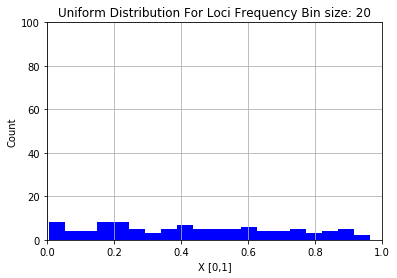

In [12]:
#use this to see distribution of f_i frequency
bin_size = 20
count, bins, ignored = plt.hist(f_M, 20, facecolor='blue') 

plt.xlabel('X [0,1]')
plt.ylabel('Count')
plt.title("Uniform Distribution For Loci Frequency Bin size: "+str(bin_size))
plt.axis([0, 1, 0, 100]) # x_start, x_end, y_start, y_end
plt.grid(True)

plt.show(block = False)

In [19]:
#split data into test and train
X = G[:,0:len(G[0])-2]

#last column is the appended Y vector we predicted
y = G[:,len(G[0])-1]

#split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

linReg = LinearRegression()  

#training the algorithm
linReg.fit(x_train, y_train) 

# train the model
#svr_rbf.fit(x_train, y_train)

#test the model on test data
y_predict = linReg.predict(x_test)

In [23]:
#Evaluate the regression model
print("Mean absolute error =", round(metrics.mean_absolute_error(y_test, y_predict), 2)) 
print("Mean squared error =", round(metrics.mean_squared_error(y_test, y_predict), 2)) 
print("Root Mean squared error =", sqrt(round(metrics.mean_squared_error(y_test, y_predict), 2)))
print("Median absolute error =", round(metrics.median_absolute_error(y_test, y_predict), 2)) 
print("Explain variance score =", round(metrics.explained_variance_score(y_test, y_predict), 2)) 
print("R2 score =", round(metrics.r2_score(y_test, y_predict), 2))

Mean absolute error = 0.47
Mean squared error = 0.35
Root Mean squared error = 0.5916079783099616
Median absolute error = 0.4
Explain variance score = 0.71
R2 score = 0.71


In [24]:
#initialize tree with a node depth of 10 and 50 decision trees
forReg = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=50)
forReg.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


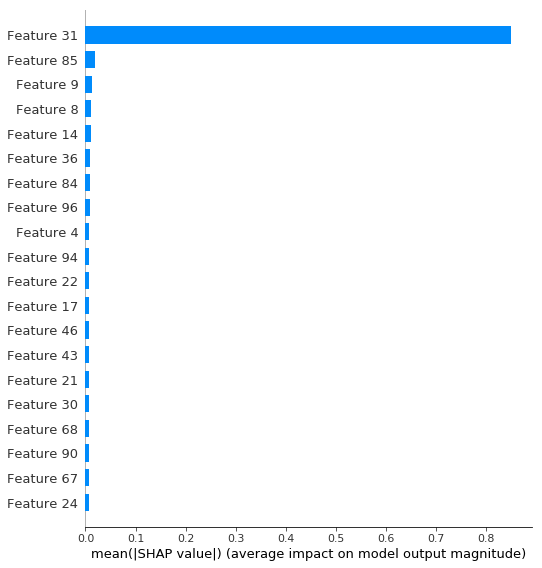

In [25]:
shap_values = shap.TreeExplainer(forReg).shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar")

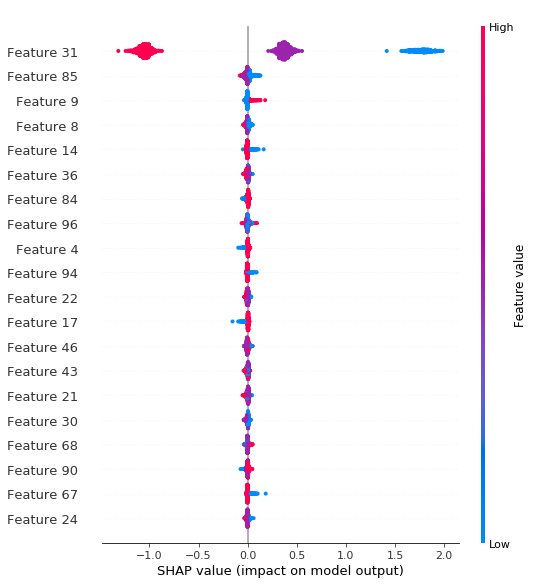

In [26]:
shap.summary_plot(shap_values,x_train)

In [17]:
def trait_simulation(samples_n, loci_m,var_g,var_e):
    f_M = np.random.uniform(0,1,loci_m)
    G = np.random.binomial(n=2,p = f_M, size = (samples_n,loci_m))
    G = preprocessing.scale(G, axis=0)
    loci =random.randint(0,loci_m-1)
    SNP = G[:,loci]
    individuals = len(SNP)
    mean = 0 
    sigma_b = sqrt(var_g)
    sigma_e = sqrt(var_e)
    b_i = np.random.normal(0, sigma_b)
    Y_n = np.zeros((individuals, 1))
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G_ij will be the jth individual from our SNP for the loci of choce
        G_ij  = SNP[k]
        Y_j = b_i*G_ij + e_j
        Y_n[k] = Y_j 
    H= var_g/(var_g+var_e)
    G = np.append(G, Y_n, axis=1)
    X = G[:,0:len(G[0])-2]
    y = G[:,len(G[0])-1]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    linReg = LinearRegression()  
    linReg.fit(x_train, y_train) 
    explainer = shap.KernelExplainer(linReg.predict, x_train)
    shap_values = explainer.shap_values(x_train)
    #print(x_train.shape)
    shap_values = shap_linear_regression(G)
    #print(shap_feature_plot(shap_values))
    return shap_values,loci
print(trait_simulation(10, 20, 0.7, 0.3))

Data with input dtype int32 was converted to float64 by the scale function.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_


((array([[ 0.05345811, -0.00245108,  0.        ,  0.        ,  0.06579907,
         0.04805756, -0.04013572, -0.00382608, -0.1866993 , -0.0361779 ,
         0.04227418, -0.06125016,  0.06114529, -0.08642785, -0.03040153,
        -0.01821923, -0.0310574 , -0.01146354,  0.00425437],
       [-0.04009358,  0.01470648,  0.        ,  0.        , -0.01096651,
         0.04805756, -0.04013572,  0.02295646,  0.14002448, -0.0361779 ,
         0.04227418,  0.06125016, -0.2241994 ,  0.21606962,  0.07600383,
        -0.01821923, -0.0310574 , -0.01146354,  0.00425437],
       [ 0.05325484,  0.        ,  0.        ,  0.        , -0.01121718,
        -0.12034191, -0.04020265, -0.00407193,  0.13988962,  0.21674527,
         0.14065656,  0.        ,  0.0609443 , -0.08673501,  0.07576764,
        -0.01852569, -0.03132643, -0.01162474,  0.        ],
       [-0.04014232, -0.00248715,  0.        ,  0.        , -0.01106343,
        -0.12016771, -0.04015911, -0.00387731, -0.18672389, -0.0362231 ,
        -0.

In [18]:
#Breaking into smaller functions
def simulate_genotype(samples_n, loci_m):
    f_M = np.random.uniform(0,1,loci_m)
    G = np.random.binomial(n=2,p = f_M, size = (samples_n,loci_m))
    G = preprocessing.scale(G, axis=0)
    return G

def simulate_genotype_and_phenotype(samples_n, loci_m,var_g,var_e):
    G = simulate_genotype(samples_n, loci_m)
    loci =random.randint(0,loci_m-1)
    SNP = G[:,loci]
    individuals = len(SNP)
    mean = 0 
    sigma_b = sqrt(var_g)
    sigma_e = sqrt(var_e)
    b_i = np.random.normal(0, sigma_b)
    Y_n = np.zeros((individuals, 1))
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G_ij will be the jth individual from our SNP for the loci of choce
        G_ij  = SNP[k]
        Y_j = b_i*G_ij + e_j
        Y_n[k] = Y_j 
    H= var_g/(var_g+var_e)
    G = np.append(G, Y_n, axis=1)
    return G, loci

In [52]:
#Linear ML functions & SHAP
def shap_linear_regression(G):
    #H= var_g/(var_g+var_e)
    X = G[:,0:len(G[0])-2]
    y = G[:,len(G[0])-1]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    linReg = LinearRegression()  
    linReg.fit(x_train, y_train) 
    y_predict = linReg.predict(x_test)
    '''
    print("Mean absolute error =", round(metrics.mean_absolute_error(y_test, y_predict), 2)) 
    print("Mean squared error =", round(metrics.mean_squared_error(y_test, y_predict), 2)) 
    print("Root Mean squared error =", sqrt(round(metrics.mean_squared_error(y_test, y_predict), 2)))
    print("Median absolute error =", round(metrics.median_absolute_error(y_test, y_predict), 2)) 
    print("Explain variance score =", round(metrics.explained_variance_score(y_test, y_predict), 2)) 
    print("R2 score =", round(metrics.r2_score(y_test, y_predict), 2))
    '''
    root_mean_sqr = sqrt(round(metrics.mean_squared_error(y_test, y_predict), 2))
    explainer = shap.KernelExplainer(linReg.predict, x_train)
    shap_values = explainer.shap_values(x_train)
    return shap_values, root_mean_sqr, linReg

def shap_feature_plot_LR(shap_values, linReg):
    shap_values = shap.TreeExplainer(linReg).shap_values(x_train)
    shap.summary_plot(shap_values, x_train, plot_type="bar")
    
def shap_random_forest(G):
    X = G[:,0:len(G[0])-2]
    y = G[:,len(G[0])-1]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    forReg = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=50)
    forReg.fit(x_train, y_train)
    
    shap_values = shap.TreeExplainer(forReg).shap_values(x_train)
    return shap_values, x_train

def shap_feature_plot_RF(shap_values, x_train):
    shap.summary_plot(shap_values, x_train, plot_type="bar")
    
    

19


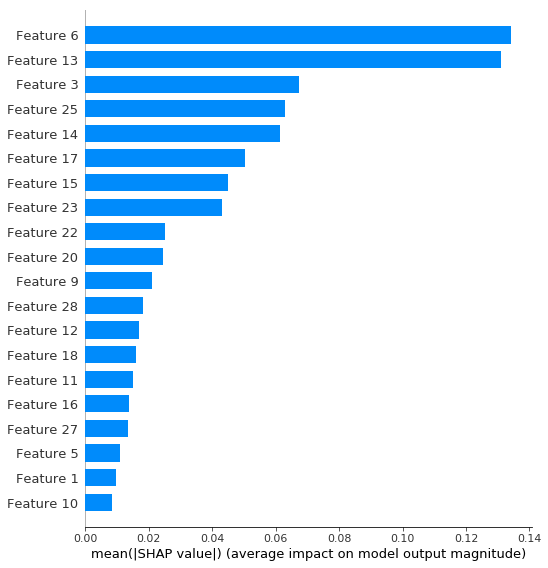

(13, 0.01888234773169347)


In [78]:
G, loci = simulate_genotype_and_phenotype(50,30, .4, .5)
print(loci)
shap_values2, x_train = shap_random_forest(G)
shap_feature_plot_RF(shap_values2, x_train)
print(max_mean_feature(shap_values2))

In [55]:
import warnings
warnings.filterwarnings('ignore')
shap_values, SNP = trait_simulation(30,100,.4,.5)

In [114]:
#SHAP vs noise
#def linear_regression_vs_noise(samples_n, loci_m,var_g,var_e, number_of_trials):
def mean_shap_values(shap_values):
    if len(shap_values) == 2:
        mean_shap = [0] * len(shap_values[0][0])
        for shap_value in shap_values[0]:
            #print(shap_value)
            for x in range(0, len(shap_value)):
                mean_shap[x] = mean_shap[x] + shap_value[x]
        for x in range(0, len(shap_values[0])):
            mean_shap[x] = abs(mean_shap[x] / len(shap_values[0]))
    else:    
        mean_shap = [0] * len(shap_values[0])
        for shap_value in shap_values:
            for x in range(0, len(shap_value)):
                mean_shap[x] = mean_shap[x] + shap_value[x]
        for x in range(0, len(shap_values[0])):
            mean_shap[x] = abs(mean_shap[x] / len(shap_values[0]))
    return mean_shap                   

def max_mean_feature(shap_values):
    mean_shap = mean_shap_values(shap_values)
    return mean_shap.index(max(mean_shap)), mean_shap[mean_shap.index(max(mean_shap))]

def avg_shap_values(samples_n, loci_m,var_g,var_e, number_of_trials):
    trail_shap_values = []
    for trail in range(0, number_of_trials):
        shap_values,SNP = trait_simulation(samples_n, loci_m,var_g,var_e)
        max_mean_shap = max_mean_feature(shap_values)
        trail_shap_values.append(max_mean_shap[1])
    return sum(trail_shap_values)/len(trail_shap_values)

def plot_shap_values_basic(samples_n, loci_m, range_var, trials, raw_value = True, envi_noise = True):
    
    increment = 1/range_var
    holderg = 0
    holdere = 1
    var_g = [0]
    var_e = [1]
    
    if envi_noise:
        for x in range(1, range_var):
            var_g.append(holderg + increment)
            var_e.append(holdere - increment)
            holderg = holderg + increment
            holdere = holdere - increment
    else:
        for x in range(1, range_var):
            var_g.append(holderg + increment)
            holderg = holderg + increment
        var_e += ([0] * len(var_g))

    shap_values_SNP = []
    
    if raw_value:
        for x in range(0,range_var):
            shap_values_SNP.append(shap_per_var_g(samples_n, loci_m, var_g[x], var_e[x], trials))
    else:
        for x in range(0,range_var):
            shap_values_SNP.append(shap_per_var_g_correctness(samples_n, loci_m, var_g[x], var_e[x], trials))

            
    plt.plot(var_g, shap_values_SNP) 
    plt.xlabel('Variance of Genetic Effect')
    if raw_value:
        plt.ylabel('SHAP value of causal SNP')
        plt.title('Effect of noise on SHAP values of correct loci') 
    else:
        plt.ylabel('Percent accuracy of feature selection')
        plt.title('Effect of noise on SHAP Accuracy in Feature Selection') 
    plt.show()
    
def plot_shap_values(samples_n, loci_m, range_var, trials, raw_value = True):
    
    increment = 1/range_var
    holderg = 0
    holdere = 1
    var_g = [0]
    var_e = [1]
    
    for x in range(1, range_var):
        var_g.append(holderg + increment)
        var_e.append(holdere - increment)
        holderg = holderg + increment
        holdere = holdere - increment

    shap_values_SNP = []
    
    if raw_value:
        for y in range(0, range_var):
            for x in range(0,range_var):
                shap_values_SNP.append(shap_per_var_g(samples_n, loci_m, var_g[x], var_e[y], trials))
    else:
        for y in range(0, range_var):
            for x in range(0,range_var):
                shap_values_SNP.append(shap_per_var_g(samples_n, loci_m, var_g[x], var_e[y], trials))

    for shap_value in shap_values_SNP:
        plt.plot(var_g, shap_value) 
    
    plt.xlabel('Variance of Genetic Effect')
    if raw_value:
        plt.ylabel('SHAP value of causal SNP')
        plt.title('Effect of noise on SHAP values of correct loci') 
    else:
        plt.ylabel('Percent accuracy of feature selection')
        plt.title('Effect of noise on SHAP Accuracy in Feature Selection') 
    plt.show()
    
def shap_per_var_g(samples_n, loci_m, var_g, var_e, number_trials):
    shap_values_SNP = []
    counter = 0
    while counter != number_trials:
        G, loci = simulate_genotype_and_phenotype(samples_n,loci_m, var_g , var_e )
        shap_values_holder, x_train = shap_random_forest(G)
        max_holder = max_mean_feature(shap_values_holder)
        
        if max_holder[0] == loci:
            shap_values_SNP.append(max_holder[1])
        else:
            shap_values_SNP.append(0)
        counter += 1
    return sum(shap_values_SNP) / len(shap_values_SNP)

def shap_per_var_g_correctness(samples_n, loci_m, var_g, var_e, number_trials):
    shap_values_SNP = []
    counter = 0
    while counter != number_trials:
        G, loci = simulate_genotype_and_phenotype(samples_n,loci_m, var_g , var_e )
        shap_values_holder, x_train = shap_random_forest(G)
        max_holder = max_mean_feature(shap_values_holder)
        if max_holder[0] == loci:
            shap_values_SNP.append(1)
        else:
            shap_values_SNP.append(0)
        counter += 1
    return sum(shap_values_SNP) / len(shap_values_SNP) * 100
        

Heritability Constraint


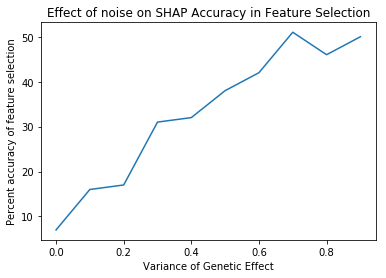

Heritability Constraint


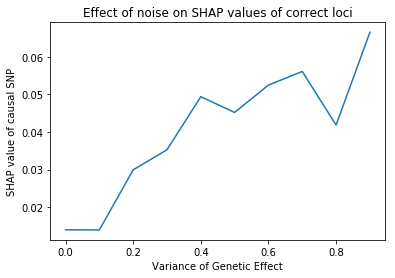

envi constraint to 0


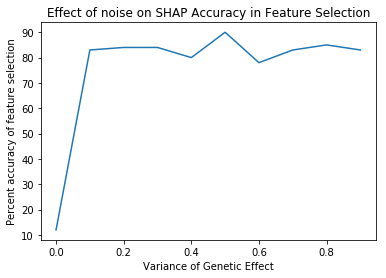

envi constraint to 0


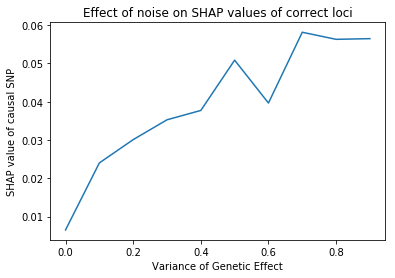

In [115]:
print("Heritability Constraint")
plot_shap_values_basic(50, 10, 10, 100, False)
print("Heritability Constraint")
plot_shap_values_basic(50, 10, 10, 100)
print("envi constraint to 0")
plot_shap_values_basic(50, 10, 10, 100, False, False)
print("envi constraint to 0")
plot_shap_values_basic(50, 10, 10, 100, True, False)
